In [1]:
import h5py
import numpy as np

In [2]:

def read_fidelity_stats(hdf5_file):
    """
    Reads the Fidelity field from the HDF5 file and calculates the minimum, mean, and median Fidelity
    for each time duration of training for each gamma.

    Parameters:
    hdf5_file (str): Path to the HDF5 file.

    Returns:
    fidelity_stats (dict): A dictionary with gamma values as keys and sub-dictionaries containing arrays of 
                           min, mean, and median fidelities indexed by sorted time durations.
    """
    fidelity_stats = {}

    with h5py.File(hdf5_file, 'r') as f:
        # Iterate over all gamma groups
        for gamma_key in f.keys():
            print(f"Processing gamma: {gamma_key}")
            
            gamma_group = f[gamma_key]  # Access the gamma group
            
            min_fidelities = []
            mean_fidelities = []
            median_fidelities = []
            durations = []

            # Iterate over time duration groups inside each gamma group
            for duration_key in gamma_group.keys():
                duration_group = gamma_group[duration_key]

                all_fidelities = []
                # Collect all fidelity values for this time duration
                for state_key in [f"D{i}" for i in range(1, 11)]:
                    if state_key in duration_group:
                        state_group = duration_group[state_key]
                        
                        # Read the Fidelity data
                        if 'Fidelity' in state_group:
                            fidelity_data = state_group['Fidelity'][()]
                            
                            # Check if Fidelity is a scalar or an array
                            if np.isscalar(fidelity_data):
                                all_fidelities.append(fidelity_data)  # Append scalar directly
                            else:
                                all_fidelities.extend(fidelity_data)  # Flatten and append array elements

                # If we have collected fidelities for this time duration, calculate stats
                if all_fidelities:
                    all_fidelities = np.array(all_fidelities)
                    min_fidelity = np.min(all_fidelities)
                    mean_fidelity = np.mean(all_fidelities)
                    median_fidelity = np.median(all_fidelities)

                    # Store the values
                    min_fidelities.append(min_fidelity)
                    mean_fidelities.append(mean_fidelity)
                    median_fidelities.append(median_fidelity)
                    durations.append(float(duration_key))

            # Convert lists to arrays
            durations = np.array(durations)
            min_fidelities = np.array(min_fidelities)
            mean_fidelities = np.array(mean_fidelities)
            median_fidelities = np.array(median_fidelities)

            # Sort arrays by durations
            sorted_indices = np.argsort(durations)
            durations = durations[sorted_indices]
            min_fidelities = min_fidelities[sorted_indices]
            mean_fidelities = mean_fidelities[sorted_indices]
            median_fidelities = median_fidelities[sorted_indices]

            # Store the sorted results for the current gamma
            fidelity_stats[gamma_key] = {
                'durations': durations,
                'min_fidelity': min_fidelities,
                'mean_fidelity': mean_fidelities,
                'median_fidelity': median_fidelities
            }

    return fidelity_stats

In [4]:
# Example usage
kossak_hdf5_file = 'MULT_KOSSAK_CONSTR_TSSOS_threshold_1e-15_FROB_QO_2024-Sep-29_at_19-10.h5'
kossak_fidelity_stats = read_fidelity_stats(kossak_hdf5_file)

# Example usage
lindblad_hdf5_file = 'MULT_LINDBLAD_CONSTR_TSSOS_threshold_1e-15_FROB_QO_2024-Sep-29_at_21-07.h5'
lindblad_fidelity_stats = read_fidelity_stats(lindblad_hdf5_file)

Processing gamma: 0.079477
Processing gamma: 0.25133
Processing gamma: 0.79477
Processing gamma: 2.5133
Processing gamma: 25.133
Processing gamma: 251.33
Processing gamma: 7.9477
Processing gamma: 79.477
Processing gamma: 0.079477
Processing gamma: 0.25133
Processing gamma: 0.79477
Processing gamma: 2.5133
Processing gamma: 25.133
Processing gamma: 251.33
Processing gamma: 7.9477
Processing gamma: 79.477


In [6]:
import matplotlib.pyplot as plt
from matplotlib import cm

In [40]:
def plot_infidelity_stats(lindblad_fidelity_stats, kossak_fidelity_stats):
    """
    Plots the fidelity statistics for each gamma on the same plot using sorted gamma values
    and a plasma color palette.

    Parameters:
    fidelity_stats (dict): The dictionary containing fidelity statistics for each gamma.
    """
    # Sort gamma keys by their numeric value
    sorted_gamma_keys = sorted(lindblad_fidelity_stats.keys(), key=lambda x: float(x))
    
    # Use the plasma colormap
    cmap = cm.get_cmap('plasma', len(sorted_gamma_keys))

    plt.figure(figsize=(10, 6))

    # Iterate over sorted gamma keys and plot its min, mean, and median fidelities for Lindblad models
    for i, gamma_key in enumerate(sorted_gamma_keys[0:4]):
        stats = lindblad_fidelity_stats[gamma_key]
        durations = stats['durations']
        mean_fidelity = stats['mean_fidelity']
        
        color = cmap(i)  # Assign a color from the plasma colormap
        gamma_durations = [i/2 for i in range(1, len(mean_fidelity)+1)]
        
        # Plot mean fidelity for Lindblad models with 'o' marker
        plt.semilogy(gamma_durations, 1 - mean_fidelity, marker='o', markerfacecolor='none', color=color, alpha=1, label=f'γ = {gamma_key}')

    plt.plot([], [], marker='o', markerfacecolor='none', color='black', linestyle='None', label='Lindblad models')

    # Iterate over sorted gamma keys and plot its min, mean, and median fidelities for Kossakowski models
    for i, gamma_key in enumerate(sorted_gamma_keys[4:8]):
        stats = kossak_fidelity_stats[gamma_key]
        durations = stats['durations']
        mean_fidelity = stats['mean_fidelity']
        
        color = cmap(i+4)  # Assign a color from the plasma colormap
        gamma_durations = [i/2 for i in range(1, len(mean_fidelity)+1)]

        # Plot mean fidelity for Kossakowski models with '^' marker
        plt.semilogy(gamma_durations, 1 - mean_fidelity, marker='^', markerfacecolor='none', color=color, alpha=1, label=f'γ = {gamma_key}')

    # Add a custom legend entry for the marker types
    
    plt.plot([], [], marker='^', markerfacecolor='none', color='black', linestyle='None', label='Kossakowski models')

    # Add plot labels and legend
    plt.xlim(0, 7)
    plt.xlabel(r'Training duration, $\gamma^{-1}$')
    plt.ylabel(r'Mean infidelity, $1-F$')
    #plt.title('Mean infidelity of Kossakowski and Lindblad models')
    
    # Display the full legend with gamma values and model types, using 2 or 3 columns
    plt.legend(loc='best', ncol=2)  # Change ncol to 3 if needed fontsize='small',

    plt.grid(True)
    
    # Save and show the plot
    plt.savefig("InFid_by_train_Kossak_Lindblad.pdf")
    plt.show()

/tmp/ipykernel_23978/4227680283.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('plasma', len(sorted_gamma_keys))


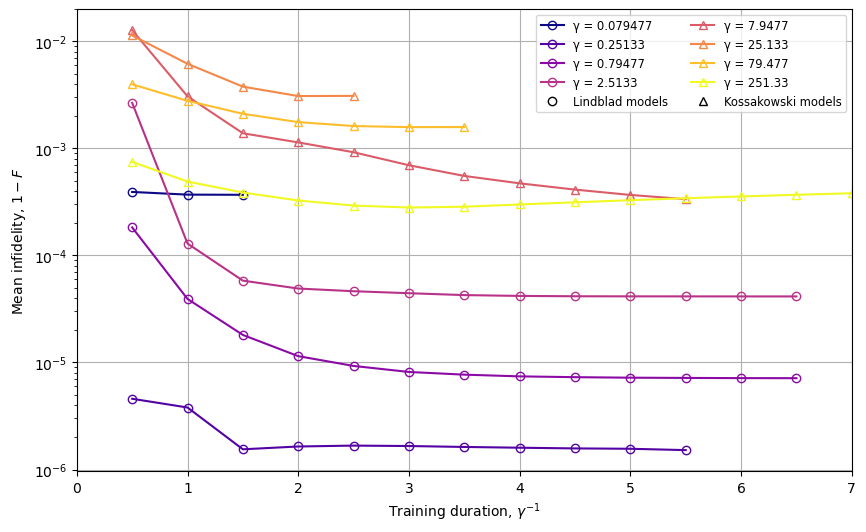

In [41]:
plot_infidelity_stats(lindblad_fidelity_stats, kossak_fidelity_stats)